# Table of Contents
[1.Train vs Test sample](#train_test_split)

[2.Model scoring](#model_scoring)

[3.Confusion matrix](#model_scoring)

[2.K-fold cross validation](#k_fold_cross_validation)

[4.Hyper Parameters](#hyper_parameters)

[5.Detecting overfitting and underfitting](#bias_variance_analysis)

In [1]:
import datetime as dt
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd


from __future__ import print_function, division
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

%matplotlib notebook

C:\Users\GRANVILLE\Anaconda2\Lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


We build the different file names, we'll use to build our model and make submission:
    - TRAINING_FILE   : Dataset we'll used for training/validating our model
    - TEST_FILE       : Test file with no categories, we'll use to make predictions and submit
    - SUBMISSION_FILE : Template of submission file

In [49]:
DATA_DIR = ".\\data"

TRAINING_FILE = os.path.join(DATA_DIR, "train.csv")
TEST_FILE = os.path.join(DATA_DIR, "test.csv")
SUBMISSION_FILE = os.path.join(DATA_DIR, "sampleSubmission.csv")

We create an helper class which will be used to load/format/plot the data and generate prediction files

In [50]:
class SFCrimesUtils(object):
    @staticmethod
    def get_df(fileName):
        df = pd.read_csv(fileName,parse_dates=["Dates"])
        df["year"] = df["Dates"].dt.year
        df["month"] = df["Dates"].dt.month
        df["day"] = df["Dates"].dt.day
        df["hour"] = df["Dates"].dt.hour
        df["minute"] = df["Dates"].dt.minute
        return df
    
    @staticmethod
    def format_df(df):
        df_train = pd.get_dummies(df[["DayOfWeek"]])
        df_train["hour"] = df["hour"]
        if 'Category' in df.columns:
            df_train["Category"] = df["Category"]
        df_train["X"] = df["X"]
        df_train["Y"] = df["Y"]

        return df_train
    
    @staticmethod
    def get_train_test_data(df, size=0, rdm_state=0):
        Y = df.Category.values
        df_train = df.drop(labels="Category", axis=1)
        X = df_train[df_train.columns.values].values
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=size,random_state=rdm_state)
        return (X_train, X_test, Y_train, Y_test)
    
    @staticmethod
    def scale_data(X, sc=None, fit=True):
        if sc is None:
            sc = StandardScaler()
        if fit==True:
            sc.fit(X)
        return sc.transform(X),sc
    
    @staticmethod
    def generate_csv(csv_target_name, csv_template_name, clf, Y_Pred):
        df_sub = pd.read_csv(csv_template_name, index_col=0)
        columns = df_sub.columns.values
        if False in np.equal(columns, clf.classes_):
            print("columns from submission %s different from prediction %s",columns,clf.classes_)
            return
        for i in df_sub.index.values:
            df_sub.iloc[i] = Y_Pred[i]        
        df_sub.to_csv(csv_target_name,compression="gzip")
    
    @staticmethod
    def predict(clf, test_file_name, scaler):
        df_test = SFCrimesUtils.get_df(test_file_name)
        df_test = SFCrimesUtils.format_df(df_test)
        X_test = df_test[df_test.columns.values].values
        if not scaler is None:
            X_test, sc = SFCrimesUtils.scale_data(X_test,scaler,fit=False)
            return clf.predict_proba(X_test)  
        return clf.predict_proba(X_test)    
    
    @staticmethod
    def plot_conf_matrix(Y_test, Y_pred):
        labels = np.unique(Y_test)
        cm = confusion_matrix(Y_test, Y_pred, labels)
        plt.figure(figsize=(10,10))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=90)
        plt.yticks(tick_marks, labels)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    @staticmethod 
    def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")

        plt.legend(loc="best")
        plt.show()
    
    @staticmethod
    def plot_validation_curve(estimator, X, y, param_name, param_range, cv=3, scoring="log_loss"):
        train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.figure()
        plt.title("Validation Curve")
        plt.plot(param_range, train_mean, color='blue', marker='o',markersize=5,label='training accuracy')
        plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
        plt.plot(param_range, test_mean, color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
        plt.fill_between(param_range,test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
        plt.grid()
        plt.xscale('log')
        plt.legend(loc='lower right')
        plt.xlabel('Parameter max_depth')
        plt.ylabel('Accuracy')
        plt.show()    

Let's load the data and get them ready

In [51]:
train = SFCrimesUtils.get_df(TRAINING_FILE)
train

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,year,month,day,hour,minute
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,33
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23,30
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23,30
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,2015,5,13,23,30
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,2015,5,13,23,30
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015,5,13,23,30
8,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,RICHMOND,NONE,600 Block of 47TH AV,-122.508194,37.776601,2015,5,13,23,0
9,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,JEFFERSON ST / LEAVENWORTH ST,-122.419088,37.807802,2015,5,13,23,0


We extract only the features we need

In [52]:
train = SFCrimesUtils.format_df(train)
train.head()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,hour,Category,X,Y
0,0,0,0,0,0,0,1,23,WARRANTS,-122.425892,37.774599
1,0,0,0,0,0,0,1,23,OTHER OFFENSES,-122.425892,37.774599
2,0,0,0,0,0,0,1,23,OTHER OFFENSES,-122.424363,37.800414
3,0,0,0,0,0,0,1,23,LARCENY/THEFT,-122.426995,37.800873
4,0,0,0,0,0,0,1,23,LARCENY/THEFT,-122.438738,37.771541



<a id='train_test_split'></a>
# Train vs Test sample

Let's split the data into 2 folds
    - Test
    - Train
The total number of sample in test will be determined using a predefined ratio

In [53]:
TEST_RATIO = 0.3
%time X_train, X_test, Y_train, Y_test = SFCrimesUtils.get_train_test_data(train, size=TEST_RATIO, rdm_state=0)
X_train

Wall time: 618 ms


array([[   1.        ,    0.        ,    0.        , ...,   21.        ,
        -122.45070992,   37.76952623],
       [   0.        ,    0.        ,    0.        , ...,   17.        ,
        -122.40652099,   37.78506294],
       [   0.        ,    1.        ,    0.        , ...,   16.        ,
        -122.3923934 ,   37.73374516],
       ..., 
       [   0.        ,    0.        ,    0.        , ...,   21.        ,
        -122.4115931 ,   37.78305295],
       [   0.        ,    0.        ,    0.        , ...,   11.        ,
        -122.40724409,   37.78656476],
       [   0.        ,    0.        ,    1.        , ...,   13.        ,
        -122.38643767,   37.71918345]])

In [54]:
print("Number of sample in test: %d", len(X_test))
print("Number of sample in test: %d", len(X_train))
print("Computed Ratio: %f", float(len(X_test))/(len(X_train) + len(X_test)))

('Number of sample in test: %d', 263415)
('Number of sample in test: %d', 614634)
('Computed Ratio: %f', 0.30000034166658124)


<a id='model_scoring'></a>
# Model Scoring

Let's instanciate our random forest classifier

In [55]:
%time rfc = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=2)

Wall time: 0 ns


Before fitting our classifier, we need to prepare our data. Since our features have very
different range, we will standardize them

In [56]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)

Wait !!! Actually we're using random forest classifier....So no need for data re-scaling     
So we're now ready to start the model fitting

In [57]:
%time rfc.fit(X_train, Y_train)

Wall time: 21.3 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Our model is now fit. let's make predictions

In [58]:
%time Y_pred =  rfc.predict(X_test)

Wall time: 2.56 s


Which score did I achieve on the test fold ?

In [59]:
print("NB SAMPLE TESTED: %d" % len(X_test))
print("GOOD CLASSIFICATIONS: %d" % np.sum(np.equal(Y_pred, Y_test)))
print("ACURACY: %f" % rfc.score(X_test, Y_test))

NB SAMPLE TESTED: 263415
GOOD CLASSIFICATIONS: 63744
ACURACY: 0.241991


Actually Kaggle relies on the log loss. What is my log loss score ?

In [60]:
Y_pred_proba = rfc.predict_proba(X_test)
print ("LOG LOSS SCORE: %f" % log_loss(y_pred=Y_pred_proba, y_true=Y_test))

LOG LOSS SCORE: 15.372285


<a id='confusion_matrix'></a>
# Confusion Matrix

<IPython.core.display.Javascript object>


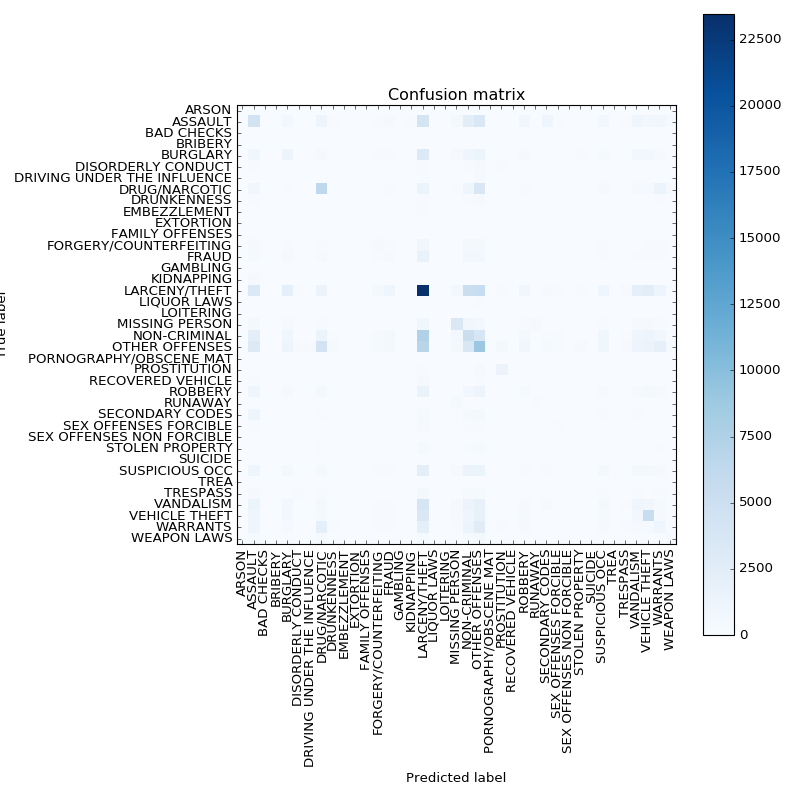

In [61]:
SFCrimesUtils.plot_conf_matrix(Y_test, Y_pred)

<a id='k_fold_cross_validation'></a>
# K-Fold cross validation

Let's rebuild the Train,Test sample with nothing allocated to the test

In [62]:
TEST_RATIO = 0
%time X_train, X_test, Y_train, Y_test = SFCrimesUtils.get_train_test_data(train, size=TEST_RATIO, rdm_state=0)
X_train

Wall time: 514 ms


array([[   1.        ,    0.        ,    0.        , ...,   17.        ,
        -122.39045898,   37.75518672],
       [   0.        ,    0.        ,    0.        , ...,   18.        ,
        -122.42556893,   37.76140295],
       [   0.        ,    0.        ,    0.        , ...,   16.        ,
        -122.41483476,   37.74734523],
       ..., 
       [   0.        ,    0.        ,    0.        , ...,   21.        ,
        -122.4115931 ,   37.78305295],
       [   0.        ,    0.        ,    0.        , ...,   11.        ,
        -122.40724409,   37.78656476],
       [   0.        ,    0.        ,    1.        , ...,   13.        ,
        -122.38643767,   37.71918345]])

Now we can perform a cross-validation on X_train

In [63]:
%time scores_rfc = cross_val_score(estimator=rfc, X=X_train, y=Y_train, cv=2, scoring='log_loss')

Wall time: 48.9 s


In [64]:
print("SCORES %s"% scores_rfc)
print("MEAN %f / STD: %f" % (np.mean(scores_rfc) ,np.std(scores_rfc)))

SCORES [-15.77700447 -15.76545856]
MEAN -15.771232 / STD: 0.005773


<a id='hyper_parameters'></a>
# Hyper Parameters

Is there a way to find the optimal parameters to get the best possible score ?    
We now define the parameters we want to use for the optimization.

In [65]:
params= [
               {
                'n_estimators'      : [10],
                'max_depth'         : [1,3,5],
                'min_samples_split' : [2, 5, 10],
                'criterion'         : ["entropy", "gini"],
               }
        ]

We define the gridsearch element

In [66]:
gs = GridSearchCV(estimator=rfc,
                  param_grid=params,
                  scoring="log_loss",
                  cv=2)

In [67]:
TEST_RATIO = 0.3
%time X_train, X_test, Y_train, Y_test = SFCrimesUtils.get_train_test_data(train, size=TEST_RATIO, rdm_state=0)
gs.fit(X_train, Y_train)

Wall time: 734 ms


GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10], 'min_samples_split': [2, 5, 10], 'criterion': ['entropy', 'gini'], 'max_depth': [1, 3, 5]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=0)

In [68]:
print("Best score %s",gs.best_score_)
print("Best params %s",gs.best_params_)

('Best score %s', -2.5828352098542426)
('Best params %s', {'min_samples_split': 5, 'n_estimators': 10, 'criterion': 'entropy', 'max_depth': 5})


In [69]:
Y_pred_proba = gs.best_estimator_.predict_proba(X_test)
print ("LOG LOSS SCORE: %f" % log_loss(y_pred=Y_pred_proba, y_true=Y_test))

LOG LOSS SCORE: 2.590124


Let's make a Kaggle submission using this indicator   
First let's make predictions on the test file

In [70]:
%time Y_pred_kaggle = SFCrimesUtils.predict(gs.best_estimator_, TEST_FILE, sc) 

Wall time: 8.55 s


Now we generate the csv

In [71]:
TARGET_CSV_NAME = os.path.join(DATA_DIR, "submission_best_rfc.csv")
%time SFCrimesUtils.generate_csv(TARGET_CSV_NAME, SUBMISSION_FILE, gs.best_estimator_, Y_pred_kaggle)

Wall time: 3min 33s


<a id='bias_variance_analysis'></a>
# Detecting overfitting and underfitting

There seems to be a significant bias in our model

<IPython.core.display.Javascript object>


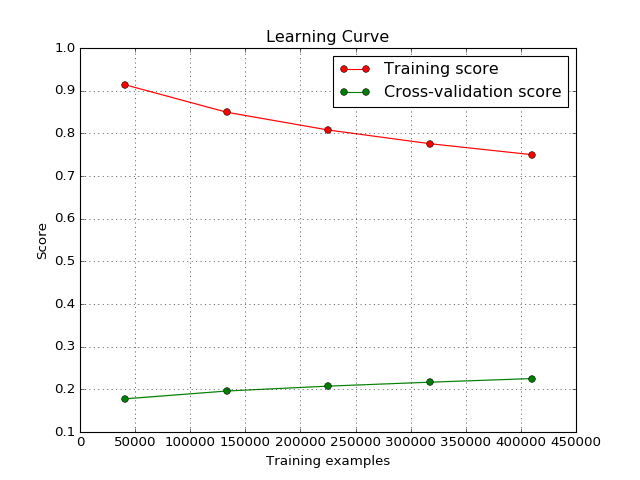

Wall time: 2min 52s


In [72]:
%time SFCrimesUtils.plot_learning_curve(estimator=rfc, X=X_train, y=Y_train, title="Learning Curve")

<IPython.core.display.Javascript object>


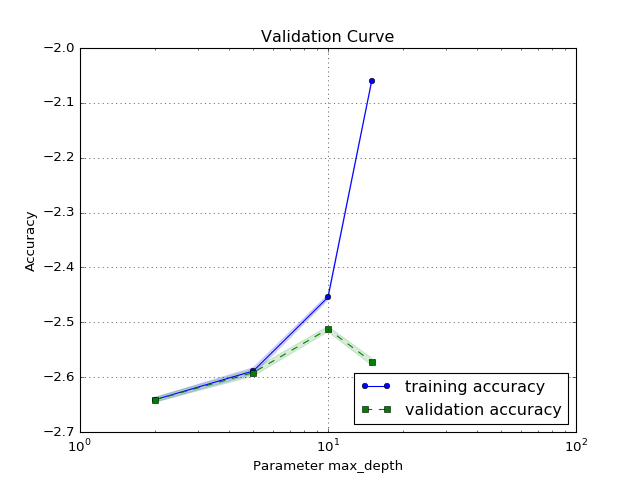

Wall time: 2min 39s


In [73]:
%time SFCrimesUtils.plot_validation_curve(estimator=rfc, X=X_train, y=Y_train, param_name="max_depth", param_range =[2,5,10,15])